# Contents

Overview
1. Imports
2. Data preprocessing
3. EDA
4. Data Preparation
5. Models:
    * A - Vanilla NN
    * B - CNN
    * C - CNN + BN & MaxPool
    * D - CNN + L2 Reg
    * E - CNN + Dropout
    * F - CNN + L2 Reg + Dropout
    * G - CNN + L2 Reg + Dropout + DataAug
    * H - CNN + L2 Reg + Dropout(0.2) + DataAug (Extra layer)
    * I - CNN + L2 Reg + Dropout(0.1) + DataAug (Extra layer)



# Overview

**Data** : The Fashion MNIST Dataset is a collection of 60K train images of 10 fashion item classes. It contains classes such as T-shirt/top, Trouser, Dress, Sneaker, Bag, etc.

**Model** : In this notebook, I attempt to compare the performance of 9 different model architectures.

**Training** : For the both models, Adam optimizer, Sparse Categoriccal Crossentropy loss function was used. The model was trained for 20-30 epochs on most cases. However, in the models with Augmentation, Calls Backs involving early stopping and LR reduce on Plateau was used with epochs limit set to 200.

**Accuracy** : The model performed excellent with an accuracy of 90% on the test data for the simple NN architecture while it performed with a accuracy of 94% using the CNN architecture.

**Future Improvements**: It could be challenging to improve the model further due to overlapping representations of some of the classes. It seems the model performance on par to a Human, based on error analysis reported through classification report and confusion matrix.

# 1. Import

In [ ]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


# 2. Data Preprocessing

Load all data and split them into cross validation and test data. Process the given data into tensors.

In [ ]:
def load_preprocess_data(split=False,debug = False):
  # Load raw dataset
  fashion_mnist = keras.datasets.fashion_mnist 
  (train_data,train_labels),(test_data,test_labels)=fashion_mnist.load_data()

  # Print shape of raw dataset during debug
  if debug== True:
    print("Before Pre processing:")
    print("X_Train and Y_Train Shape:",train_data.shape,train_labels.shape)
    print("X_Test and Y_Test Shape:",test_data.shape,test_labels.shape)

  
  # Rescaling
  train_data,test_data=train_data/255,test_data/255
  
  # Reshape as tensors
  X_train = np.reshape(train_data, (train_data.shape[0], 28, 28, 1), order='C') 
  y_train = np.reshape(train_labels, (train_data.shape[0], 1), order='C') 
  
  # Split data into validation and testing
  if split == True:
    random_indices = np.linspace(0,test_data.shape[0]-1,test_data.shape[0],dtype=int)
    random_indices = np.random.permutation(random_indices)
    
    split_index = int(len(random_indices)*0.2)
    
    X_val = test_data[random_indices[:split_index]]
    y_val = test_labels[random_indices[:split_index]]
    
    X_test = test_data[random_indices[split_index:]]
    y_test = test_labels[random_indices[split_index:]]

    X_val = np.reshape(X_val, (len(X_val), 28, 28, 1), order='C') 
    y_val = np.reshape(y_val, (len(y_val), 1), order='C') 

    X_test = np.reshape(X_test, (len(X_test), 28, 28, 1), order='C') 
    y_test = np.reshape(y_test, (len(y_test), 1), order='C') 

  else:
    X_test = np.reshape(test_data, (len(test_data), 28, 28, 1), order='C') 
    y_test = np.reshape(test_labels, (len(test_data), 1), order='C') 

  # Print shape of processed dataset during debug
  if debug== True:
    print("After processing:")
    print("X_Train and Y_Train Shape:",X_train.shape,y_train.shape)
    if split==True:
      print("X_Validation and Y_Validation Shape:",X_val.shape,y_val.shape)
    
    print("X_Test and Y_Test Shape:",X_test.shape,y_test.shape)

  if split== False:
    return (X_train,y_train),(X_test,y_test),(train_data,train_labels)
  else:
    return (X_train,y_train),(X_val,y_val),(X_test,y_test),(train_data,train_labels)


In [ ]:
class_names={
  0:	'T-shirt/top',
  1:	'Trouser',
  2:	'Pullover',
  3:	'Dress',
  4:	'Coat',
  5:	'Sandal',
  6:	'Shirt',
  7:	'Sneaker',
  8:	'Bag',
  9:	'Ankle boot'}
class_names_str= np.array([val for (val) in class_names.values()],dtype=str)

In [ ]:
(X_train,y_train),(X_val,y_val),(X_test,y_test),(train_data,train_labels) = load_preprocess_data(split=True,debug = True)

Before Pre processing:
X_Train and Y_Train Shape: (60000, 28, 28) (60000,)
X_Test and Y_Test Shape: (10000, 28, 28) (10000,)
After processing:
X_Train and Y_Train Shape: (60000, 28, 28, 1) (60000, 1)
X_Validation and Y_Validation Shape: (2000, 28, 28, 1) (2000, 1)
X_Test and Y_Test Shape: (8000, 28, 28, 1) (8000, 1)


# 3. EDA

In [ ]:
def do_eda(train_data,n = 25):
  plt.figure(figsize=(7,7))
  # Show N samples
  for i in range(n):
    plt.subplot((int(n/5)+1),5,i+1)
    plt.tick_params( which='both', bottom=False, left=False,top=False,labelbottom=False, labelleft=False) 
    # Get the class names from labels
    plt.xlabel(class_names[train_labels[i]])
    plt.imshow(train_data[i])
    plt.tight_layout()

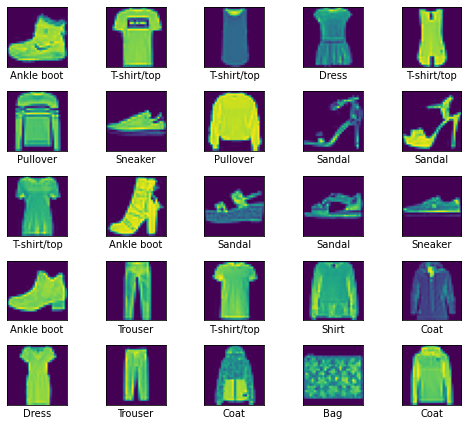

In [ ]:
do_eda(train_data)

In [ ]:
def do_plot(hist,title):
  print('\n\n')
  plt.figure(figsize=(14,5))
  plt.suptitle(title, fontsize=16,va='bottom')

  # Plot Accuracy of training and validation data
  plt.subplot(1,2,1)
  plt.grid(axis='both')
  plt.plot(np.linspace(0,hist.epoch[-1],len(hist.epoch)),hist.history['val_accuracy'],color='r',marker = 'o')
  plt.plot(np.linspace(0,hist.epoch[-1],len(hist.epoch)),hist.history['accuracy'],color='b',marker = 'o')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Validation','Training'])
  plt.xlim(0,hist.epoch[-1])
  plt.xticks(ticks=hist.epoch)
  
  # Plot Loss of training and validation data
  plt.subplot(1,2,2)
  plt.grid(axis='both')
  plt.plot(np.linspace(0,hist.epoch[-1],len(hist.epoch)),hist.history['val_loss'],color='r',marker = 'o')
  plt.plot(np.linspace(0,hist.epoch[-1],len(hist.epoch)),hist.history['loss'],color='b',marker = 'o')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Validation','Training'])
  plt.xlim(0,hist.epoch[-1])  
  plt.xticks(ticks=hist.epoch)
  
  plt.tight_layout()
  plt.show()  

In [ ]:
def train_and_evaluate(model_x,X_train,y_train,epoch,X_val,y_val,X_test,y_test,plot_title,callbacks=[]):
  # Train and store the history of training
  hist_x = model_x.fit(X_train,y_train,epochs=epoch, validation_data = (X_val,y_val),callbacks=callbacks)

  # Plot all the accuracy and loss curves
  do_plot(hist_x,title = plot_title)

  # Evaluate Confusion and Classification report 
  eval_x = model_x.evaluate(X_test,y_test,verbose=1)
  do_eval(model_x,X_test,y_test)

  print("Training Accuracy is: ",np.average(hist_x.history['accuracy'][-5:]))
  print("Validation Accuracy is: ",np.average(hist_x.history['accuracy'][-5:]))
  print("Testing Accuracy is: ",eval_x)
  return hist_x,model_x

In [ ]:
def do_eval(model,X_test,y_test):
  pred_sparse = np.argmax(model.predict(X_test),axis=1)
  cm =confusion_matrix(y_test, pred_sparse,labels=[0,1,2,3,4,5,6,7,8,9])
  cr = classification_report(y_test, pred_sparse)
  print('Confusion Matrix\n',cm)
  print('Classification Report\n', cr)

  plt.figure()
  plt.imshow(cm)
  plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=class_names_str)
  plt.yticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=class_names_str)
  plt.ylabel('Y_True')  
  plt.xlabel('Y_Pred')
  plt.xticks(rotation=90)
  return

# 5. Vanilla Dense Neural Network

## Model - A

In [ ]:
model_a=keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ])
model_a.compile(optimizer='Adam',metrics=['accuracy'],loss='sparse_categorical_crossentropy')

Epoch 1/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6270 - accuracy: 0.7708 - val_loss: 0.4757 - val_accuracy: 0.8170
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3913 - accuracy: 0.8571 - val_loss: 0.4000 - val_accuracy: 0.8490
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3436 - accuracy: 0.8726 - val_loss: 0.3510 - val_accuracy: 0.8695
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3183 - accuracy: 0.8838 - val_loss: 0.3485 - val_accuracy: 0.8780
Epoch 5/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2937 - accuracy: 0.8926 - val_loss: 0.3339 - val_accuracy: 0.8680
Epoch 6/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2794 - accuracy: 0.8964 - val_loss: 0.3309 - val_accuracy: 0.8830
Epoch 7/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2600 - accuracy: 0.9033 - val_loss: 0.3701 - val_accuracy:

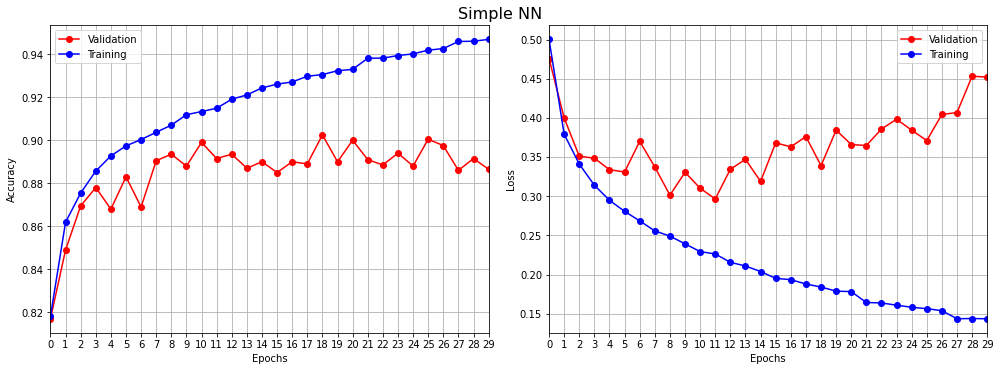

250/250 [==============================] - 1s 2ms/step - loss: 0.4645 - accuracy: 0.8880
Confusion Matrix
 [[683   2  17  12   2   1  62   0   6   0]
 [  1 773   4  10   1   0   3   0   0   0]
 [ 16   0 722   7  28   0  42   0   0   0]
 [ 28   6  14 720   9   0  23   0   2   0]
 [  1   0 138  40 540   0  65   0   1   0]
 [  0   0   0   0   0 748   0  14   1  14]
 [113   0  87  16  28   0 572   0   3   0]
 [  0   0   0   0   0   6   0 759   0  35]
 [  4   0   2   5   0   0   3   2 799   0]
 [  1   0   0   0   0   3   0  18   0 788]]
Classification Report
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       785
           1       0.99      0.98      0.98       792
           2       0.73      0.89      0.80       815
           3       0.89      0.90      0.89       802
           4       0.89      0.69      0.78       785
           5       0.99      0.96      0.97       777
           6       0.74      0.70      0.72       819
      

AttributeError: ignored

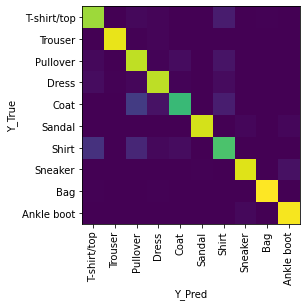

In [ ]:
hist_a,model_a = train_and_evaluate(model_a,X_train,y_train,30,X_val,y_val,X_test,y_test,"Simple NN")

In [ ]:
model_a.evaluate(X_test,y_test)

250/250 [==============================] - 1s 2ms/step - loss: 0.5289 - accuracy: 0.8960


[0.5288926959037781, 0.8960000276565552]

**Observations:**
* A simple Neural Network performs with 89%-90% accuracy. 
* The validation accuracy is considerably below the training accuracy.

Next, I utilize CNNs anticipating improvement in performance

# 6. CNN

## Model - B

In [ ]:
model_b=keras.Sequential()
model_b.add(keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)))
model_b.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
model_b.add(keras.layers.MaxPool2D((2,2)))
model_b.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
model_b.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
model_b.add(keras.layers.MaxPool2D((2,2)))
model_b.add(keras.layers.Conv2D(128,(3,3), activation='relu'))
model_b.add(keras.layers.Flatten())
model_b.add(keras.layers.Dense(1024, activation='relu'))
model_b.add(keras.layers.Dense(256, activation='relu'))
model_b.add(keras.layers.Dense(10,activation='softmax'))
# model_b.summary()
model_b.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

## Train - B 

Epoch 1/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7058 - accuracy: 0.7321 - val_loss: 0.3378 - val_accuracy: 0.8730
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3126 - accuracy: 0.8853 - val_loss: 0.3008 - val_accuracy: 0.8835
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2566 - accuracy: 0.9065 - val_loss: 0.2521 - val_accuracy: 0.9060
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2283 - accuracy: 0.9160 - val_loss: 0.2536 - val_accuracy: 0.9025
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1980 - accuracy: 0.9267 - val_loss: 0.2350 - val_accuracy: 0.9065
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1798 - accuracy: 0.9331 - val_loss: 0.2318 - val_accuracy: 0.9110
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1654 - accuracy: 0.9391 - val_loss: 0.2398 - val_accuracy:

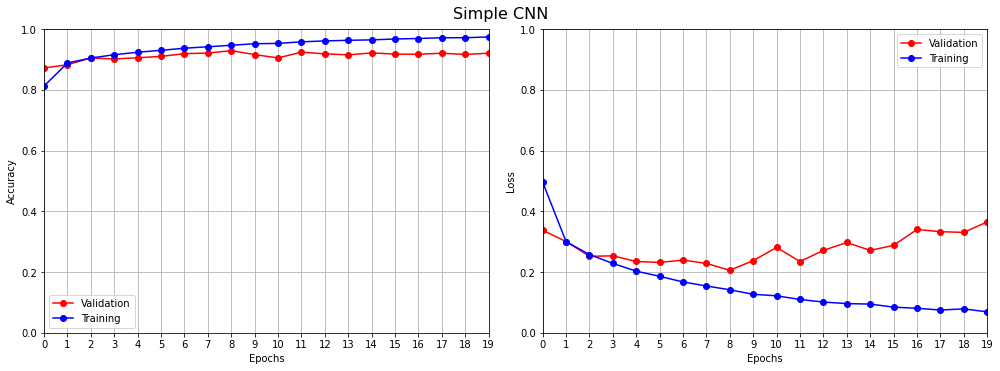

250/250 [==============================] - 1s 2ms/step - loss: 0.4118 - accuracy: 0.9135
Confusion Matrix
 [[712   0  11  17   2   1  39   0   3   0]
 [  0 779   1   8   1   0   1   0   2   0]
 [ 13   0 735   5  24   0  36   0   2   0]
 [ 13   5   8 744  13   0  18   0   1   0]
 [  1   1  43  34 667   0  38   0   1   0]
 [  0   0   0   0   0 765   0   8   0   4]
 [117   0  62  26  54   0 554   0   6   0]
 [  0   0   0   0   0   4   0 772   0  24]
 [  7   1   2   5   2   2   5   0 790   1]
 [  0   0   0   0   0   1   0  18   1 790]]
Classification Report
               precision    recall  f1-score   support

           0       0.83      0.91      0.86       785
           1       0.99      0.98      0.99       792
           2       0.85      0.90      0.88       815
           3       0.89      0.93      0.91       802
           4       0.87      0.85      0.86       785
           5       0.99      0.98      0.99       777
           6       0.80      0.68      0.73       819
      

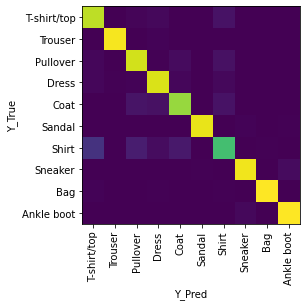

In [ ]:
hist_b,model_b = train_and_evaluate(model_b,X_train,y_train,20,X_val,y_val,X_test,y_test,"Simple CNN")
# hist_b = model_b.fit(train_data_tensor,train_label_tensor,epochs=20,validation_data=(test_data_tensor,test_label_tensor))

In [ ]:
model_b.evaluate(X_test,y_test)

250/250 [==============================] - 1s 2ms/step - loss: 0.4118 - accuracy: 0.9135


[0.41183000802993774, 0.9135000109672546]

**Observations:**
* A simple Convoluational Neural Network performs with 90%-91% accuracy, showing a 1-2% improvement. 
* The validation accuracy is still considerably below the training accuracy.

Next, I try a CNN with Batch Normalization and Max pooling layers to see if there's improvements.

# 5. CNN + BN & MaxPool

##Model - C

In [ ]:
model_c=keras.Sequential()
model_c.add(keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)))
model_c.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
model_c.add(keras.layers.MaxPool2D((2,2)))
model_c.add(keras.layers.BatchNormalization())
model_c.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
model_c.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
model_c.add(keras.layers.MaxPool2D((2,2)))
model_c.add(keras.layers.BatchNormalization())
model_c.add(keras.layers.Conv2D(128,(3,3), activation='relu'))
model_c.add(keras.layers.Flatten())
model_c.add(keras.layers.Dense(1024, activation='relu'))
model_c.add(keras.layers.Dense(256, activation='relu'))
model_c.add(keras.layers.Dense(10,activation='softmax'))
# model_c.summary()
model_c.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

Epoch 1/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5382 - accuracy: 0.8027 - val_loss: 0.3108 - val_accuracy: 0.8910
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2845 - accuracy: 0.8956 - val_loss: 0.2781 - val_accuracy: 0.8910
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2354 - accuracy: 0.9128 - val_loss: 0.2806 - val_accuracy: 0.9070
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2060 - accuracy: 0.9245 - val_loss: 0.3033 - val_accuracy: 0.8920
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1831 - accuracy: 0.9314 - val_loss: 0.2281 - val_accuracy: 0.9130
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1606 - accuracy: 0.9402 - val_loss: 0.2640 - val_accuracy: 0.9115
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1489 - accuracy: 0.9444 - val_loss: 0.2414 - val_accuracy:

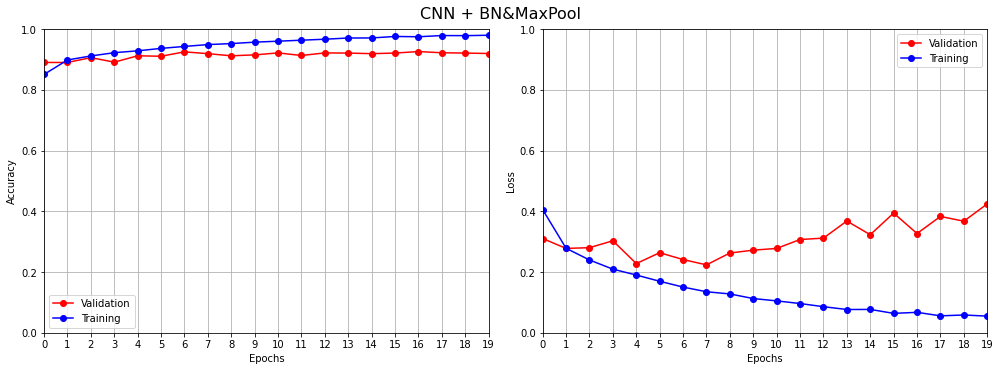

250/250 [==============================] - 1s 2ms/step - loss: 0.4148 - accuracy: 0.9176
Confusion Matrix
 [[698   0  14  14   5   1  47   0   6   0]
 [  1 776   1   8   3   0   2   0   1   0]
 [ 11   1 727   6  39   0  29   0   2   0]
 [ 14   2   7 753  16   0  10   0   0   0]
 [  1   0  31  17 715   0  21   0   0   0]
 [  3   0   0   0   0 757   0  15   1   1]
 [ 93   0  34  27  75   0 582   0   8   0]
 [  0   0   0   0   0   3   0 788   0   9]
 [  4   1   3   3   5   2   1   4 792   0]
 [  0   0   0   0   0   9   0  48   0 753]]
Classification Report
               precision    recall  f1-score   support

           0       0.85      0.89      0.87       785
           1       0.99      0.98      0.99       792
           2       0.89      0.89      0.89       815
           3       0.91      0.94      0.92       802
           4       0.83      0.91      0.87       785
           5       0.98      0.97      0.98       777
           6       0.84      0.71      0.77       819
      

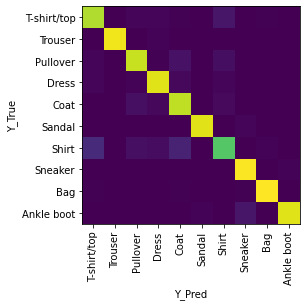

In [ ]:
hist_c,model_c = train_and_evaluate(model_c,X_train,y_train,20,X_val,y_val,X_test,y_test,"CNN + BN&MaxPool")
# hist_b = model_b.fit(train_data_tensor,train_label_tensor,epochs=20,validation_data=(test_data_tensor,test_label_tensor))

In [ ]:
model_c.evaluate(X_test,y_test)

250/250 [==============================] - 1s 3ms/step - loss: 0.4148 - accuracy: 0.9176


[0.4148454964160919, 0.9176250100135803]

**Observations:**
* A simple CNN + BN & MaxPool performs with 92%-93% accuracy, showing a 1-2% improvement. 
* The validation accuracy is still considerably below the training accuracy of 98%.

Next, I try a CNN with Batch Normalization and Max pooling layers, here onewards simply called a CNN, along with L2 regulariztion to see if there's improvements.

# 5. CNN + L2 Reg

## Model - D

In [ ]:
model_d=keras.Sequential()
model_d.add(keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)))
model_d.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
model_d.add(keras.layers.MaxPool2D((2,2)))
model_d.add(keras.layers.BatchNormalization())
model_d.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
model_d.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
model_d.add(keras.layers.MaxPool2D((2,2)))
model_d.add(keras.layers.BatchNormalization())
model_d.add(keras.layers.Conv2D(128,(3,3), activation='relu'))
model_d.add(keras.layers.Flatten())
model_d.add(keras.layers.Dense(1024, activation='relu',kernel_regularizer = tf.keras.regularizers.L2(0.001)))
model_d.add(keras.layers.Dense(256, activation='relu',kernel_regularizer = tf.keras.regularizers.L2(0.001)))
model_d.add(keras.layers.Dense(10,activation='softmax',kernel_regularizer = tf.keras.regularizers.L2(0.001)))
# model_d.summary()
model_d.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1232 - accuracy: 0.9706 - val_loss: 0.3523 - val_accuracy: 0.9125
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1176 - accuracy: 0.9726 - val_loss: 0.3634 - val_accuracy: 0.9125
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1136 - accuracy: 0.9738 - val_loss: 0.3599 - val_accuracy: 0.9090
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1103 - accuracy: 0.9751 - val_loss: 0.3444 - val_accuracy: 0.9130
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1052 - accuracy: 0.9768 - val_loss: 0.3810 - val_accuracy: 0.9105
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1024 - accuracy: 0.9777 - val_loss: 0.3868 - val_accuracy: 0.9065
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0976 - accuracy: 0.9788 - val_loss: 0.3452 - val_accuracy:

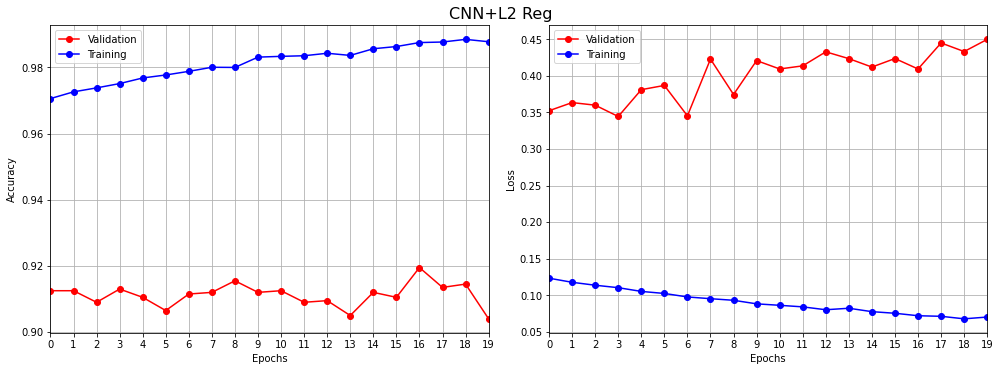

250/250 [==============================] - 1s 3ms/step - loss: 0.4467 - accuracy: 0.9075
Confusion Matrix
 [[673   0   5  11   3   0  88   0   4   0]
 [  0 793   0  12   3   0   2   0   2   0]
 [  9   0 659  10  53   0  84   0   2   0]
 [  3   3   8 747  19   0  22   0   4   0]
 [  0   0  23  16 700   0  68   0   2   0]
 [  0   0   0   0   0 780   0   9   1   6]
 [ 78   1  34  21  49   0 610   0   7   0]
 [  0   0   0   0   0   3   0 766   0  40]
 [  0   0   1   6   1   0   3   3 771   0]
 [  0   0   0   0   0   4   0  17   0 761]]
Classification Report
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       784
           1       0.99      0.98      0.99       812
           2       0.90      0.81      0.85       817
           3       0.91      0.93      0.92       806
           4       0.85      0.87      0.86       809
           5       0.99      0.98      0.99       796
           6       0.70      0.76      0.73       800
      

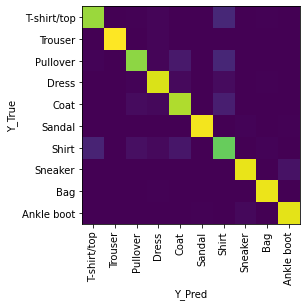

In [ ]:
hist_d,model_d = train_and_evaluate(model_d,X_train,y_train,20,X_val,y_val,X_test,y_test,"CNN+L2 Reg")
# hist_b = model_b.fit(train_data_tensor,train_label_tensor,epochs=20,validation_data=(test_data_tensor,test_label_tensor))

In [ ]:
model_d.evaluate(X_test,y_test)

**Observations:**
* A simple CNN L2 Reg performs with 91%-92% accuracy, showing a 1-2% decrease in performance. 
* The validation accuracy is still considerably below the training accuracy of 98%.

Next, I try a CNN with Dropout.

# 5. CNN + Dropout

## Model - E

In [ ]:
model_e=keras.Sequential()
model_e.add(keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)))
model_e.add(keras.layers.Conv2D(32,(3,3),activation='relu'))
model_e.add(keras.layers.MaxPool2D((2,2)))
model_e.add(keras.layers.BatchNormalization())
model_e.add(keras.layers.Dropout(0.1))
model_e.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
model_e.add(keras.layers.Conv2D(64,(3,3), activation='relu'))
model_e.add(keras.layers.MaxPool2D((2,2)))
model_e.add(keras.layers.BatchNormalization())
model_e.add(keras.layers.Dropout(0.15))
model_e.add(keras.layers.Conv2D(128,(3,3), activation='relu'))
# model_e.add(keras.layers.Conv2D(128,(3,3), activation='relu'))
model_e.add(keras.layers.MaxPool2D((2,2)))
model_e.add(keras.layers.Flatten())
model_e.add(keras.layers.Dropout(0.3))
model_e.add(keras.layers.Dense(1024, activation='relu'))
model_e.add(keras.layers.Dropout(0.1))
model_e.add(keras.layers.Dense(256, activation='relu'))
model_e.add(keras.layers.Dense(10,activation='softmax'))
# model_e.summary()
model_e.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

Epoch 1/30
1875/1875 [==============================] - 40s 4ms/step - loss: 0.6580 - accuracy: 0.7574 - val_loss: 0.3596 - val_accuracy: 0.8715
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3511 - accuracy: 0.8741 - val_loss: 0.2889 - val_accuracy: 0.8935
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3108 - accuracy: 0.8876 - val_loss: 0.2976 - val_accuracy: 0.8930
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2783 - accuracy: 0.8999 - val_loss: 0.2776 - val_accuracy: 0.8970
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2618 - accuracy: 0.9034 - val_loss: 0.2572 - val_accuracy: 0.9070
Epoch 6/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2489 - accuracy: 0.9097 - val_loss: 0.2439 - val_accuracy: 0.9135
Epoch 7/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2393 - accuracy: 0.9135 - val_loss: 0.2314 - val_accuracy

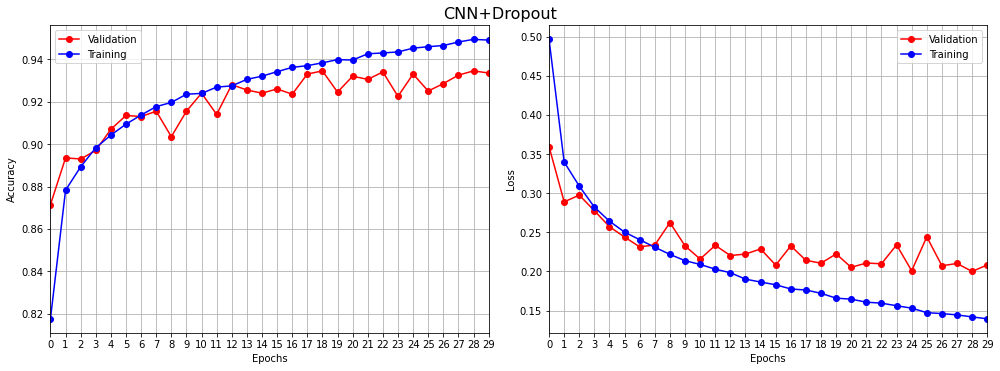

250/250 [==============================] - 1s 2ms/step - loss: 0.2225 - accuracy: 0.9275
Confusion Matrix
 [[680   2  11  13   1   1  73   0   4   0]
 [  0 781   0   8   0   0   3   0   0   0]
 [ 13   0 731   6  25   0  37   0   3   0]
 [  5   4   4 770   9   0  10   0   0   0]
 [  1   0  30  25 673   0  55   0   1   0]
 [  0   0   0   0   0 762   0  10   1   4]
 [ 69   1  44  18  30   0 654   0   3   0]
 [  0   0   0   0   0   4   0 774   0  22]
 [  5   0   0   3   0   1   3   1 802   0]
 [  0   0   0   0   0   2   0  14   1 793]]
Classification Report
               precision    recall  f1-score   support

           0       0.88      0.87      0.87       785
           1       0.99      0.99      0.99       792
           2       0.89      0.90      0.89       815
           3       0.91      0.96      0.94       802
           4       0.91      0.86      0.88       785
           5       0.99      0.98      0.99       777
           6       0.78      0.80      0.79       819
      

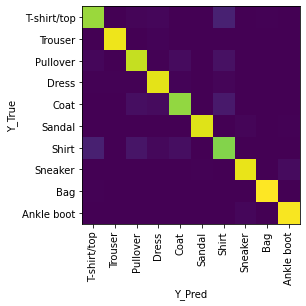

In [ ]:
hist_e,model_e = train_and_evaluate(model_e,X_train,y_train,30,X_val,y_val,X_test,y_test,"CNN+Dropout")

In [ ]:
model_e.evaluate(X_test,y_test)

**Observations:**
* A CNN + dropout performs with 93%-94% accuracy, showing a 1-2% improvement. 
* The validation accuracy is still considerably below the training accuracy of 95%.

Next, I try a CNN with Dropout and L2 Reg to see if there's improvements.

# 5. CNN + Dropout + L2 Reg

## Model - F

In [ ]:
model_f = keras.Sequential([ tf.keras.Input((28,28,1)),
                                 keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)),
                                 keras.layers.Conv2D(32,(3,3),activation='relu'),
                                 keras.layers.MaxPool2D((2,2)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dropout(0.1),
                                 keras.layers.Conv2D(64,(3,3), activation='relu'),
                                 keras.layers.Conv2D(64,(3,3), activation='relu'),
                                 keras.layers.MaxPool2D((2,2)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dropout(0.15),
                                 keras.layers.Conv2D(128,(3,3), activation='relu'),
                                 keras.layers.MaxPool2D((2,2)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dropout(0.30),
                                 tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.0001)),
                                 keras.layers.Dropout(0.1),
                                 tf.keras.layers.Dense(256, activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.0001)),
                                 tf.keras.layers.Dense(10,activation='softmax',kernel_regularizer= tf.keras.regularizers.L2(0.0001))
])
# model_f.summary()
model_f.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

Epoch 1/80
1875/1875 [==============================] - 8s 4ms/step - loss: 0.7031 - accuracy: 0.7618 - val_loss: 0.3914 - val_accuracy: 0.8765
Epoch 2/80
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3897 - accuracy: 0.8751 - val_loss: 0.3546 - val_accuracy: 0.8875
Epoch 3/80
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3329 - accuracy: 0.8934 - val_loss: 0.3217 - val_accuracy: 0.8965
Epoch 4/80
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3071 - accuracy: 0.9010 - val_loss: 0.2876 - val_accuracy: 0.9000
Epoch 5/80
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2796 - accuracy: 0.9090 - val_loss: 0.2687 - val_accuracy: 0.9090
Epoch 6/80
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2643 - accuracy: 0.9139 - val_loss: 0.2628 - val_accuracy: 0.9105
Epoch 7/80
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2518 - accuracy: 0.9181 - val_loss: 0.2677 - val_accuracy:

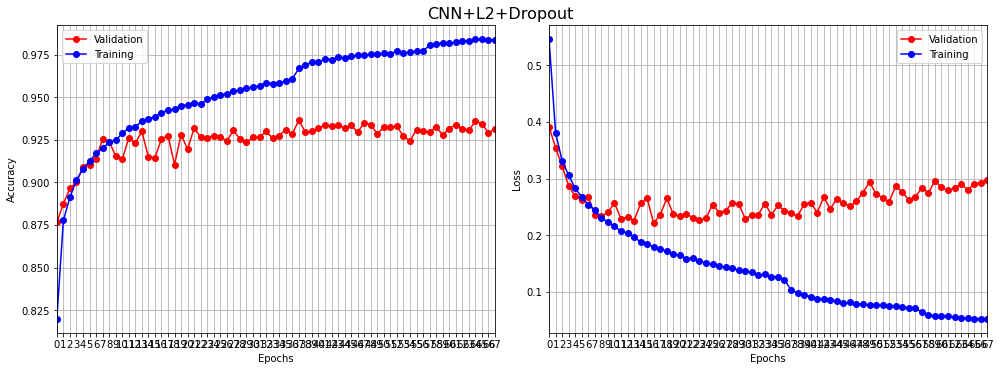

250/250 [==============================] - 1s 2ms/step - loss: 0.2913 - accuracy: 0.9300
Confusion Matrix
 [[692   0  14  13   2   1  59   0   4   0]
 [  0 775   1  13   1   0   2   0   0   0]
 [ 12   0 733   8  25   0  36   0   1   0]
 [  6   2   6 750  23   1  14   0   0   0]
 [  0   0  16  19 713   0  37   0   0   0]
 [  0   0   0   0   0 769   0   6   0   2]
 [ 78   0  29  22  47   0 637   0   6   0]
 [  0   0   0   0   0   5   0 782   0  13]
 [  3   0   0   3   0   2   3   0 804   0]
 [  0   0   0   0   0   3   0  22   0 785]]
Classification Report
               precision    recall  f1-score   support

           0       0.87      0.88      0.88       785
           1       1.00      0.98      0.99       792
           2       0.92      0.90      0.91       815
           3       0.91      0.94      0.92       802
           4       0.88      0.91      0.89       785
           5       0.98      0.99      0.99       777
           6       0.81      0.78      0.79       819
      

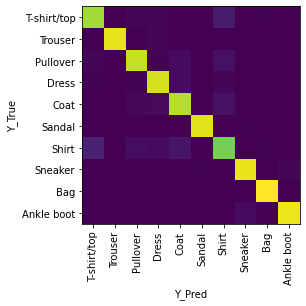

In [ ]:
hist_f,model_f = train_and_evaluate(model_f,X_train,y_train,80,X_val,y_val,X_test,y_test,"CNN+L2+Dropout",callbacks=callbacks_list_default)


In [ ]:
model_f.evaluate(X_test,y_test)

**Observations:**
* A CNN + L2 Reg+ Dropout performs with 93%-94% accuracy.
* The validation accuracy is still considerably below the training accuracy of 98%.

Next, I add Augmentation to see if there's any improvement

# 5. CNN + Dropout + L2 + Augmentation

## Model - G

In [ ]:
model_g = keras.Sequential([ tf.keras.Input((28,28,1)),
                                 tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
                                 tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                 tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),  
                                 keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)),
                                 keras.layers.Conv2D(32,(3,3),activation='relu'),
                                 keras.layers.MaxPool2D((2,2)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dropout(0.1),
                                 keras.layers.Conv2D(64,(3,3), activation='relu'),
                                 keras.layers.Conv2D(64,(3,3), activation='relu'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPool2D((2,2)),
                                 keras.layers.Dropout(0.15),
                                 keras.layers.Conv2D(128,(3,3), activation='relu'),
                                 keras.layers.MaxPool2D((2,2)),
                                 keras.layers.Flatten(),
                                 keras.layers.Dropout(0.3),
                                 tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.000001)),
                                 keras.layers.Dropout(0.1),
                                 tf.keras.layers.Dense(256, activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.000001)),
                                 tf.keras.layers.Dense(10,activation='softmax',kernel_regularizer= tf.keras.regularizers.L2(0.000001))
])
# model_g.summary()
# opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_g.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics='accuracy')

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks_list_default = [
        # reduce learning rate by a factor of 5 (i.e. lr/=5.0) 
        # if val_loss does not reduce for 3 epochs
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=20,
            verbose=1
        ),
        # Stop training if val_acc does not improve for
        # 5 or more epochs
        EarlyStopping(
            monitor='val_accuracy',
            patience=30,
            verbose=1        
        )
    ]

Epoch 1/200
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5811 - accuracy: 0.7904 - val_loss: 0.5853 - val_accuracy: 0.7880
Epoch 2/200
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5540 - accuracy: 0.8008 - val_loss: 0.5245 - val_accuracy: 0.8140
Epoch 3/200
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5297 - accuracy: 0.8101 - val_loss: 0.4778 - val_accuracy: 0.8260
Epoch 4/200
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5134 - accuracy: 0.8163 - val_loss: 0.4801 - val_accuracy: 0.8320
Epoch 5/200
1875/1875 [==============================] - 8s 5ms/step - loss: 0.4972 - accuracy: 0.8222 - val_loss: 0.4993 - val_accuracy: 0.8200
Epoch 6/200
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4871 - accuracy: 0.8259 - val_loss: 0.4188 - val_accuracy: 0.8480
Epoch 7/200
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4764 - accuracy: 0.8303 - val_loss: 0.3914 - val_ac

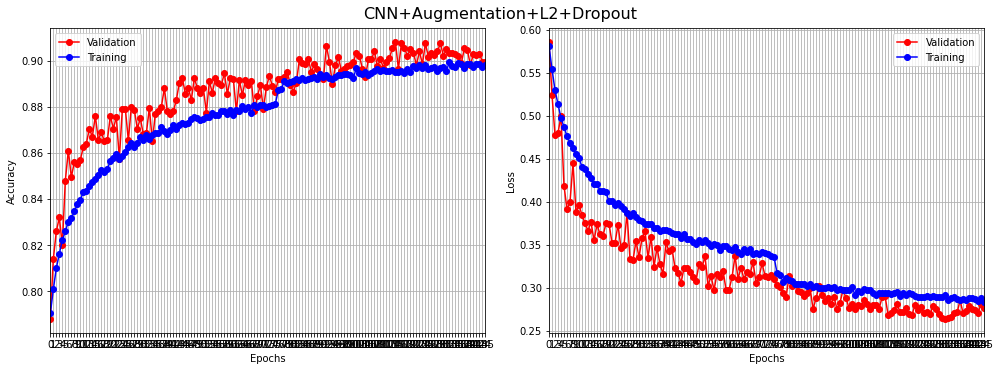

250/250 [==============================] - 1s 3ms/step - loss: 0.2680 - accuracy: 0.9069
Confusion Matrix
 [[661   0  13  14   2   0  79   0  16   0]
 [  0 772   0  13   1   0   4   0   2   0]
 [ 12   0 739   8  14   0  42   0   0   0]
 [ 15   2   8 742   8   2  21   0   4   0]
 [  0   0  53  39 622   0  69   0   2   0]
 [  0   0   0   0   0 768   0   7   1   1]
 [ 82   0  56  25  36   0 610   0  10   0]
 [  0   0   0   0   0  10   0 754   0  36]
 [  1   0   1   1   0   4   4   2 802   0]
 [  0   0   0   0   0   3   0  21   1 785]]
Classification Report
               precision    recall  f1-score   support

           0       0.86      0.84      0.85       785
           1       1.00      0.97      0.99       792
           2       0.85      0.91      0.88       815
           3       0.88      0.93      0.90       802
           4       0.91      0.79      0.85       785
           5       0.98      0.99      0.98       777
           6       0.74      0.74      0.74       819
      

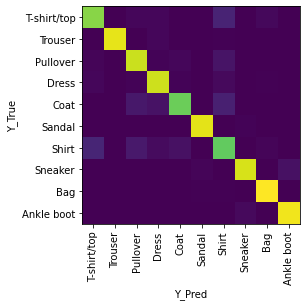

In [ ]:
hist_g,model_g = train_and_evaluate(model_g,X_train,y_train,200,X_val,y_val,X_test,y_test,"CNN+Augmentation+L2+Dropout",callbacks=callbacks_list_default)
# hist_f = model_f.fit(train_data_tensor,train_label_tensor,epochs=50,validation_data=(test_data_tensor,test_label_tensor),callbacks=callbacks_list_default)

In [ ]:
model_g.evaluate(X_test,y_test)

**Observations:**
* A CNN + L2 Reg+ Dropout+ Augmentation performs with 90%-91% accuracy.
* The validation accuracy is COMPARABLE the training accuracy of 90%.

It seems like there's too much generalization. Hence, next, I add an extra layer of CNN and reduce dropout and remove a maxpool layer

#Model H

In [ ]:
model_h = keras.Sequential([ tf.keras.Input((28,28,1)),
                                 tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
                                 tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                 tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),  
                                 keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)),
                                 keras.layers.Conv2D(32,(3,3),activation='relu'),
                                #  keras.layers.MaxPool2D((2,2)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dropout(0.1),
                                 keras.layers.Conv2D(64,(3,3), activation='relu'),
                                 keras.layers.Conv2D(64,(3,3), activation='relu'),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.MaxPool2D((2,2)),
                                 keras.layers.Dropout(0.15),
                                 keras.layers.Conv2D(128,(3,3), activation='relu'),
                                 keras.layers.Conv2D(128,(3,3), activation='relu'),
                                 keras.layers.MaxPool2D((2,2)),
                                 keras.layers.Flatten(),
                                 keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.000001)),
                                 keras.layers.Dropout(0.1),
                                 tf.keras.layers.Dense(256, activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.000001)),
                                 tf.keras.layers.Dense(10,activation='softmax',kernel_regularizer= tf.keras.regularizers.L2(0.000001))
])
# model_h.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_h.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics='accuracy')

Epoch 1/200
1875/1875 [==============================] - 13s 6ms/step - loss: 1.0672 - accuracy: 0.6038 - val_loss: 0.6471 - val_accuracy: 0.7655
Epoch 2/200
1875/1875 [==============================] - 12s 6ms/step - loss: 0.6631 - accuracy: 0.7568 - val_loss: 0.6260 - val_accuracy: 0.7770
Epoch 3/200
1875/1875 [==============================] - 12s 6ms/step - loss: 0.5852 - accuracy: 0.7895 - val_loss: 0.5730 - val_accuracy: 0.7990
Epoch 4/200
1875/1875 [==============================] - 12s 6ms/step - loss: 0.5336 - accuracy: 0.8075 - val_loss: 0.4526 - val_accuracy: 0.8320
Epoch 5/200
1875/1875 [==============================] - 12s 6ms/step - loss: 0.5078 - accuracy: 0.8200 - val_loss: 0.4639 - val_accuracy: 0.8430
Epoch 6/200
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4854 - accuracy: 0.8283 - val_loss: 0.4559 - val_accuracy: 0.8395
Epoch 7/200
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4684 - accuracy: 0.8328 - val_loss: 0.4037 -

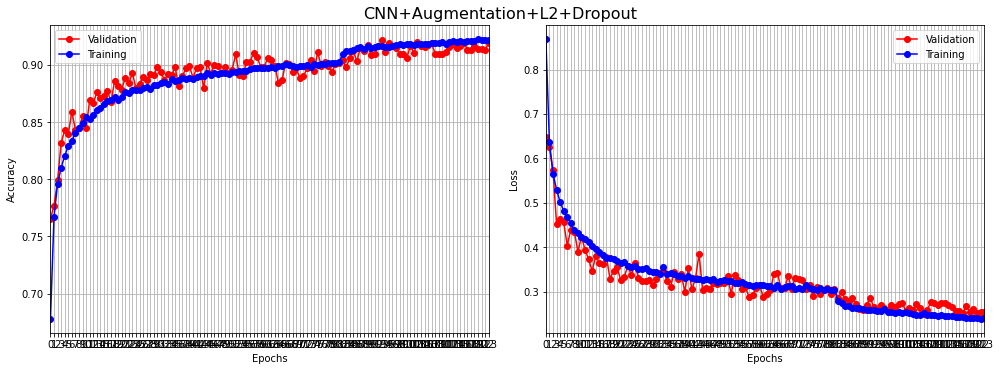

250/250 [==============================] - 1s 3ms/step - loss: 0.2564 - accuracy: 0.9174
Confusion Matrix
 [[701   0  19  11   2   1  47   0   3   1]
 [  1 780   0   8   1   0   0   0   2   0]
 [ 13   0 741   6  27   0  28   0   0   0]
 [ 19   3  14 708  34   0  22   0   1   1]
 [  1   0  30  12 709   0  31   0   2   0]
 [  0   0   0   0   0 765   0   9   1   2]
 [104   1  52  15  66   0 574   1   6   0]
 [  0   0   0   0   0   4   0 782   0  14]
 [  2   0   2   0   2   1   4   1 803   0]
 [  1   0   0   0   0   3   0  30   0 776]]
Classification Report
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       785
           1       0.99      0.98      0.99       792
           2       0.86      0.91      0.89       815
           3       0.93      0.88      0.91       802
           4       0.84      0.90      0.87       785
           5       0.99      0.98      0.99       777
           6       0.81      0.70      0.75       819
      

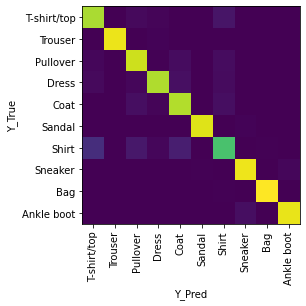

In [ ]:
hist_h,model_h = train_and_evaluate(model_h,X_train,y_train,200,X_val,y_val,X_test,y_test,"CNN+Augmentation+L2+Dropout",callbacks=callbacks_list_default)
# hist_f = model_f.fit(train_data_tensor,train_label_tensor,epochs=50,validation_data=(test_data_tensor,test_label_tensor),callbacks=callbacks_list_default)

In [ ]:
model_h.evaluate(X_test,y_test)

**Observations:**
* A CNN with modified Dropout, an extra Conv layer performs with an accuracy of 91%-92% 
* The validation accuracy is comparable to training accuracy of 98%.



In [ ]:
model_i = keras.Sequential([ tf.keras.Input((28,28,1)),
                                 keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)),
                                 keras.layers.Conv2D(32,(3,3),activation='relu'),
                                 keras.layers.MaxPool2D((2,2)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dropout(0.2),
                                 keras.layers.Conv2D(64,(3,3), activation='relu'),
                                 keras.layers.Conv2D(64,(3,3), activation='relu'),
                                 keras.layers.MaxPool2D((2,2)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dropout(0.2),
                                 keras.layers.Conv2D(128,(3,3), activation='relu'),
                                 keras.layers.MaxPool2D((2,2)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dropout(0.30),
                                 tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.00001)),
                                 keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(256, activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.00001)),
                                 tf.keras.layers.Dense(10,activation='softmax',kernel_regularizer= tf.keras.regularizers.L2(0.00001))
])
# model_f.summary()
model_i.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

Epoch 1/80
1875/1875 [==============================] - 9s 4ms/step - loss: 0.6577 - accuracy: 0.7572 - val_loss: 0.3596 - val_accuracy: 0.8780
Epoch 2/80
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3609 - accuracy: 0.8725 - val_loss: 0.3484 - val_accuracy: 0.8785
Epoch 3/80
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3235 - accuracy: 0.8866 - val_loss: 0.2762 - val_accuracy: 0.9015
Epoch 4/80
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2968 - accuracy: 0.8978 - val_loss: 0.2591 - val_accuracy: 0.9040
Epoch 5/80
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2803 - accuracy: 0.9018 - val_loss: 0.3042 - val_accuracy: 0.8935
Epoch 6/80
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2673 - accuracy: 0.9073 - val_loss: 0.2550 - val_accuracy: 0.9205
Epoch 7/80
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2530 - accuracy: 0.9126 - val_loss: 0.2602 - val_accuracy:

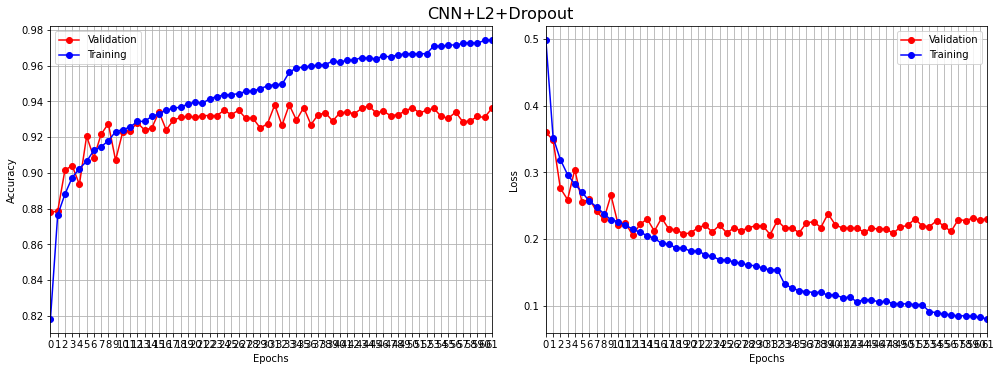

250/250 [==============================] - 1s 3ms/step - loss: 0.2372 - accuracy: 0.9356
Confusion Matrix
 [[683   0  14  10   1   2  67   0   8   0]
 [  0 779   0   7   2   0   2   0   2   0]
 [ 10   0 742   7  20   0  36   0   0   0]
 [  5   1   7 765   7   0  14   0   3   0]
 [  0   0  22  16 703   0  44   0   0   0]
 [  0   0   0   0   0 766   0   6   0   5]
 [ 59   0  35  17  35   0 668   0   5   0]
 [  0   0   0   0   0   3   0 786   0  11]
 [  0   0   0   3   1   2   0   0 809   0]
 [  0   0   0   0   0   4   0  22   0 784]]
Classification Report
               precision    recall  f1-score   support

           0       0.90      0.87      0.89       785
           1       1.00      0.98      0.99       792
           2       0.90      0.91      0.91       815
           3       0.93      0.95      0.94       802
           4       0.91      0.90      0.90       785
           5       0.99      0.99      0.99       777
           6       0.80      0.82      0.81       819
      

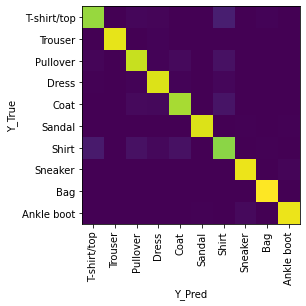

In [ ]:
hist_i,model_i = train_and_evaluate(model_i,X_train,y_train,80,X_val,y_val,X_test,y_test,"CNN+L2+Dropout",callbacks=callbacks_list_default)


In [ ]:
model_i.evaluate(X_test,y_test)

250/250 [==============================] - 1s 3ms/step - loss: 0.2372 - accuracy: 0.9356


[0.23717769980430603, 0.9356250166893005]

# Results and Conclusion

In [ ]:
results_table = pd.DataFrame(columns=['Model Arch','Train Accuracy','Val Accuracy','Test Accuracy'])
results_table = results_table.append({'Model Arch':'Neural Network','Train Accuracy':'95%','Val Accuracy':'89-90%','Test Accuracy':'89-90%'},ignore_index=True)
results_table = results_table.append({'Model Arch':'CNN','Train Accuracy':'98%','Val Accuracy':'92-93%','Test Accuracy':'92-93%'},ignore_index=True)
results_table = results_table.append({'Model Arch':'CNN + BN & Max Pool','Train Accuracy':'98%','Val Accuracy':'92-93%','Test Accuracy':'92-93%'},ignore_index=True)
results_table = results_table.append({'Model Arch':'CNN + L2','Train Accuracy':'95%','Val Accuracy':'91-92%','Test Accuracy':'91-92%'},ignore_index=True)
results_table = results_table.append({'Model Arch':'CNN + Dropout','Train Accuracy':'98%','Val Accuracy':'93-94%','Test Accuracy':'93-94%'},ignore_index=True)
results_table = results_table.append({'Model Arch':'CNN + L2 + Dropout','Train Accuracy':'98%','Val Accuracy':'93-94%','Test Accuracy':'93-94%'},ignore_index=True)
results_table = results_table.append({'Model Arch':'CNN + L2 + Dropout + Aug','Train Accuracy':'90%','Val Accuracy':'90-91%','Test Accuracy':'90-91%'},ignore_index=True)
results_table = results_table.append({'Model Arch':'CNN + L2 + Dropout(0.2) + Aug + 1 Conv','Train Accuracy':'93%','Val Accuracy':'91-90%','Test Accuracy':'90-91%'},ignore_index=True)
results_table = results_table.append({'Model Arch':'CNN + L2 + Dropout(0.1) + Aug + 1 Conv','Train Accuracy':'98%','Val Accuracy':'93-94%','Test Accuracy':'93-94%'},ignore_index=True)
results_table['index'] = ['A','B','C','D','E','F','G','H','I']
results_table.set_index('index')


,Model Arch,Train Accuracy,Val Accuracy,Test Accuracy
index,,,,
A,Neural Network,95%,89-90%,89-90%
B,CNN,98%,92-93%,92-93%
C,CNN + BN & Max Pool,98%,92-93%,92-93%
D,CNN + L2,95%,91-92%,91-92%
E,CNN + Dropout,98%,93-94%,93-94%
F,CNN + L2 + Dropout,98%,93-94%,93-94%
G,CNN + L2 + Dropout + Aug,90%,90-91%,90-91%
H,CNN + L2 + Dropout(0.2) + Aug + 1 Conv,93%,91-90%,90-91%
I,CNN + L2 + Dropout(0.1) + Aug + 1 Conv,98%,93-94%,93-94%


**Conclusion**
* Data augmentation doesn't improve the model. Dropout and L2 reg gives the best performance of 94% 
* The major cause of error is missclassification of labels Shirt - Tshirt - Coat between each other.
* This error would be difficult to eliminate as even a human might have difficulty in identifying the images especially at such low resolutions.